In [109]:
import time
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple
from dataclasses import dataclass

# @@..............................,(((((((((((((((((((((((((((%(((((((((((((#.,,.,
# @@..............................,/(((((((&@%(((###(((((((((((%(((((((((((((.,,.,
# @@...............................,/((((&@@&@/        (&&#(((((%((((((((((((#...,
# @@.................................,((%(*          &@%@@@@(((((#((((((((((((....
# @@.,...............................,.#(/                (@ %((((((((((((((((..,,
# @@....................................#                  (.  #((%((((((((((*,,,,
# @@..................................,/    .         # #.       %(#((((((((%,,,,,
# @@..................................,** **%/     .      #       #&(((((((((..,,,
# @@.................................,*  ,%@#.    * ,,,,, /        .(((((((%/,,,,.
# @@..............................,,,.% .*@@/      #,/@@@#.        #(#(((((((((&.,
# @@............................,%          ,,    /.%@@@@*        #(((#((((((((((%
# @@..........................,*                   #&@@*         (((((&@##((((((((
# @@.,........................./                               #((((*      %((((((
# @@.........................,,*                                     *.    #((((#,
# @@.........................,../               .         /        ,  ,   /((#,,,,
# @@......................,,,@@@@@@@@@,    (@@@@@@@@@@@@@@@             (........,
# @@..........,.,..,,,......,%@@@@@@@@@@@@@@@@@@@@@@@@@@@@       *&&((%,.........,
# @@.........,,#   *%,,,,,,,,.,(@@@@@@@#  @@@@@@@@@@@@@@%        #(((&.,.........,
# @@.,.......#                 .@   (,,%   %&@&&@@@@@*          #(((%.,..........,
# @@.,.......,             ,         ,..,   %#                 #((((%.............
# @@..........,.,%  /%    ./       .  *.,. /&#                /(((((.,...........,
# @@..............,*         &        ,.,,,                  /%(((((/............,
# @@.,............./         .       ,....,(                 (,.,.........,,......
# @@...............,. &@     (     # %....,.%#%(#%##%#%#/###%%#%%%#(%%%(#(%###%,.,


#                                   spaghetti


In [129]:
def debug_save(img, path):
    cv2.imwrite(f"debug/{path}.png", img)


def normalize_line(line):
    line = line[0]
    line = line.copy()

    while line[1] > np.pi:
        line[0] *= -1
        line[1] -= np.pi

    while line[1] < 0:
        line[0] *= -1
        line[1] += np.pi

    return [line]


def are_duplicates(line_a, line_b, rho_threshold, theta_threshold):
    rho_a, theta_a = line_a[0]
    rho_b, theta_b = line_b[0]

    if rho_a < 0:
        rho_a = -rho_a
        theta_a += np.pi

    if rho_b < 0:
        rho_b = -rho_b
        theta_b += np.pi

    rho_diff = (theta_a - theta_b + np.pi) % (2 * np.pi) - np.pi

    if abs(rho_diff) < theta_threshold and abs(rho_a - rho_b) < rho_threshold:
        return True
    else:
        return False


def is_axis_aligned(line, threshold):
    rho, theta = line[0]

    if 0 <= theta <= threshold or np.pi - threshold <= theta <= np.pi or np.pi/2 - threshold <= theta <= np.pi/2 + threshold:
        return True
    else:
        return False


def auto_canny(image, sigma=0.33):
    #bluring the image
    v = np.median(image)
    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edges = cv2.Canny(image, lower, upper)

    edges = cv2.dilate(edges, np.ones([3, 3]), iterations=2)
    edged = cv2.erode(edges, np.ones([3, 3]), iterations=2)
    return edges


def is_horizontal(line, threshold):
    rho, theta = line[0]

    if np.pi/2 - threshold <= theta % np.pi <= np.pi/2 + threshold:
        return True
    else:
        return False


def is_vertical(line, threshold):
    rho, theta = line[0]

    if 0 <= theta <= threshold or np.pi - threshold <= theta % np.pi <= np.pi:
        return True
    else:
        return False


def simplify_image(img, limit, grid, iters):
        """Simplify image using CLAHE algorithm (adaptive histogram
        equalization)."""
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # img = cv2.bilateralFilter(img, 7, 50, 50)
        # img = cv2.medianBlur(img, 5)
        # img = cv2.GaussianBlur(img, (5, 5), 1)

        for _ in range(iters):
            img = cv2.createCLAHE(clipLimit=limit, tileGridSize=grid).apply(
                img)
        # debug_save(img, "slid_clahe_@1")
        if limit != 0:
            kernel = np.ones((10, 10), np.uint8)
            img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
            # debug_save(img, "slid_clahe_@2")
        return img


def find_edges(img):
    edges = auto_canny(img)
    # edges = cv2.GaussianBlur(edges, (5, 5), 2)
    return edges


def find_lines(edges: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    lines = cv2.HoughLines(edges, rho = 1,theta = 1*np.pi/180,threshold = 30)
    if lines is None:
        return np.zeros([0, 1, 2]), np.zeros([0, 1, 2])
    lines = lines[:200]
    return lines


def remove_duplicate_lines(lines):
    lines = np.array([
        line for index, line in enumerate(lines) if
        all([not are_duplicates(x, line, 5, 5*np.pi/180) for x in lines[:index]])
    ])
    return lines


def split_lines_into_hv(lines) -> Tuple[np.ndarray, np.ndarray]:
    h_lines = np.array([line for line in lines if is_horizontal(line, 15*np.pi/180)])
    v_lines = np.array([line for line in lines if is_vertical(line, 15*np.pi/180)])
    return h_lines, v_lines


def overlay_lines(img, lines, color):
    img = img.copy()

    for line in lines:
        rho,theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))

        cv2.line(img, (x1,y1), (x2,y2), color, 1)

    return img

In [111]:
def intersection(line1, line2):

    rho1, theta1 = line1[0]
    rho2, theta2 = line2[0]

    # if lines are almost parallel, we skip them
    if abs(theta1 - theta2) < 0.00001:
        return None

    A = np.array([
        [np.cos(theta1), np.sin(theta1)],
        [np.cos(theta2), np.sin(theta2)]
    ])
    b = np.array([[rho1], [rho2]])
    x0, y0 = np.linalg.solve(A, b)
    x0, y0 = int(np.round(x0)), int(np.round(y0))
    return [x0, y0]


def are_intersecting_in_range(line1, line2, xy_min, xy_max):
    intersect = intersection(line1, line2)
    if intersect is None:
        return False

    return xy_min[0] < intersect[0] < xy_max[0] and xy_min[1] < intersect[1] < xy_max[1]


def segmented_intersections(h_lines, v_lines):
    intersections = []
    for h_line in h_lines:
        for v_line in v_lines:
            # horizontal lines and vertical lines always intersect so no None check
            intersections.append(intersection(h_line, v_line))

    return intersections

def overlay_markers(img, points, color=(255, 0, 0)):
    img = img.copy()
    for x, y in points:
        cv2.drawMarker(img, (x, y), markerSize=20, thickness = 5, color=color)
    return img


In [127]:
import math

# dwie funkcje totalnie nie ukradzione ze stacka

def average_angles(angles):
    """Average (mean) of angles

    Return the average of an input sequence of angles. The result is between
    ``0`` and ``2 * math.pi``.
    If the average is not defined (e.g. ``average_angles([0, math.pi]))``,
    a ``ValueError`` is raised.
    """

    x = sum(math.cos(a) for a in angles)
    y = sum(math.sin(a) for a in angles)

    if x == 0 and y == 0:
        raise ValueError(
            "The angle average of the inputs is undefined: %r" % angles)

    # To get outputs from -pi to +pi, delete everything but math.atan2() here.
    return math.fmod(math.atan2(y, x) + 2 * math.pi, 2 * math.pi)


def subtract_angles(lhs, rhs):
    return math.fmod((lhs - rhs) + math.pi * 3, 2 * math.pi) - math.pi


# k.i.s.s.
def remove_intersecting_lines(lines, are_vertical: bool):
    @dataclass
    class NpArrayWrapper:
        value: np.ndarray
        position_at_min: int = 0
        position_at_max: int = 0
        ratio_at_min: float = 0
        ratio_at_max: float = 0

        # bez tego nie działa bo ndarray nie umie się porównać :<
        def __eq__(self, other):
            return self is other

    if lines.shape == 0 or lines.shape[0] == 0:
        return lines

    line_wrappers = []
    for line in lines:
        line_wrappers.append(NpArrayWrapper(line))

    certain_lines = []

    min_pos = 0
    max_pos = 512
    for current_line in line_wrappers:
        if are_vertical:
            current_line.position_at_min = intersection(current_line.value, [[min_pos, np.pi/2]])[0]
            current_line.position_at_max = intersection(current_line.value, [[max_pos, np.pi/2]])[0]
        else:
            current_line.position_at_min = intersection(current_line.value, [[min_pos, 0.0]])[1]
            current_line.position_at_max = intersection(current_line.value, [[max_pos, 0.0]])[1]

    for index, current_line in enumerate(line_wrappers):
        if all([
            not are_intersecting_in_range(current_line.value, other.value, (min_pos-128, min_pos-128), (max_pos+128, max_pos+128)) for other in line_wrappers if other is not current_line
        ]):
            certain_lines.append(current_line)

    for line_wrapper in certain_lines:
        line_wrappers.remove(line_wrapper)

    certain_lines = sorted(certain_lines, key=lambda x: x.position_at_min)

    while line_wrappers:
        current_line = line_wrappers[0]
        prev_certain_line = None
        next_certain_line = None

        for certain_line in certain_lines:
            if certain_line.position_at_min > current_line.position_at_min:
                next_certain_line = certain_line
                break

        for certain_line in reversed(certain_lines):
            if certain_line.position_at_min < current_line.position_at_min:
                prev_certain_line = certain_line
                break

        intersecting_lines = [
            other for other in line_wrappers[1:] if are_intersecting_in_range(current_line.value, other.value, (min_pos-128, min_pos-128), (max_pos+128, max_pos+128))
        ]
        intersecting_lines.append(current_line)

        for line_wrapper in intersecting_lines:
            if next_certain_line and prev_certain_line:
                line_wrapper.ratio_at_max = (next_certain_line.position_at_max - line_wrapper.position_at_max) / (next_certain_line.position_at_max - prev_certain_line.position_at_max)
                line_wrapper.ratio_at_min = (next_certain_line.position_at_min - line_wrapper.position_at_min) / (next_certain_line.position_at_min - prev_certain_line.position_at_min)
            elif neighbour_line := next_certain_line or prev_certain_line:
                line_wrapper.ratio_at_min = neighbour_line.position_at_min - line_wrapper.position_at_min
                line_wrapper.ratio_at_max = neighbour_line.position_at_max - line_wrapper.position_at_max
            else:
                pass
                # raise Exception("Programiście jeszcze nie chciało się pomyśleć co wtedy")

        intersecting_lines = sorted(intersecting_lines, key=lambda x: abs(x.ratio_at_max - x.ratio_at_min))

        best_line = intersecting_lines[0]
        certain_lines.append(best_line)
        for line_wrapper in intersecting_lines:
            line_wrappers.remove(line_wrapper)

    result = [line_wrapper.value for line_wrapper in certain_lines]
    return result

In [113]:
def remove_suspiciously_narrow_lines(lines, center_position: int, are_vertical: bool, accespted_min_width: float = 0.8, accespted_max_width: float = 1.5):
    @dataclass
    class NpArrayWrapper:
        value: np.array
        position: int = 0
        offset_from_prev: int = None
        offset_to_next: int = None

    # lines could be sorted by rho, but we need better distance metric anyway

    line_wrappers = [NpArrayWrapper(line) for line in lines]

    if len(line_wrappers) < 2:
        return lines

    for line_wrapper in line_wrappers:
        if are_vertical:
            line_wrapper.position = intersection(line_wrapper.value, [[center_position, np.pi/2]])[0]
        else:
            line_wrapper.position = intersection(line_wrapper.value, [[center_position, 0.0]])[1]

    line_wrappers = sorted(line_wrappers, key=lambda x: x.position)

    for index in range(1, len(line_wrappers)):
        line_wrappers[index].offset_from_prev = line_wrappers[index].position - line_wrappers[index - 1].position

    # marcin nie bij, ja wiem, że liczę dwa razy to samo
    for index in range(0, len(line_wrappers) - 1):
        line_wrappers[index].offset_to_next = line_wrappers[index + 1].position - line_wrappers[index].position

    median_gap = np.median([line_wrapper.offset_from_prev for line_wrapper in line_wrappers[1:]])

    result_lines = []

    for line_wrapper in line_wrappers:
        if (line_wrapper.offset_from_prev and accespted_min_width < line_wrapper.offset_from_prev/median_gap < accespted_max_width)\
                or (line_wrapper.offset_to_next and accespted_min_width < line_wrapper.offset_to_next/median_gap < accespted_max_width):
            result_lines.append(line_wrapper)

    # if there are more than 9 lines, some must be unnecessary
    if len(result_lines) > 9:
        result_lines = sorted(result_lines, key=lambda x: x.offset_from_prev or x.offset_to_next, reverse=True)[:9]
        result_lines = sorted(result_lines, key=lambda x: x.position)

    return np.array([line_wrapper.value for line_wrapper in result_lines])

In [121]:
def create_vertical_line(x1, x2, y2):
    """
    LOS IMPORTANTE !!! y1 = 0 !!!
    Wyprowadzone na kartce, może zadziałą
    """
    d = (y2**2 + (x2 - x1)**2)**0.5
    rho = y2 * x1 / d
    theta = math.acos(y2 / d)

    line = [[rho, theta]]
    return normalize_line(line)


def create_horizontal_line(y1, x2, y2):
    """
    LOS IMPORTANTE !!! x1 = 0 !!!
    """
    rho, theta = create_vertical_line(x1=y1, x2=y2, y2=x2)[0]

    line = [[np.pi/2 - rho, theta]]
    return normalize_line(line)


def insert_missing_lines(lines, min_center_gap, are_vertical: bool):
    if len(lines) > 9:
        raise Exception("More than 9 lines at this stage of processing is an error!")
    if len(lines) == 9:
        return lines
    if len(lines) < 8:
        raise Exception("Missing more than one line is not yet implemented")

    @dataclass
    class NpArrayWrapper:
        value: np.ndarray
        position_at_min: int = 0
        position_at_max: int = 0
        offset_from_prev_at_min: int = None
        offset_to_next_at_min: int = None
        offset_from_prev_at_max: int = None
        offset_to_next_at_max: int = None

    line_wrappers = [NpArrayWrapper(line) for line in lines]

    def insert_missing_line():
        nonlocal line_wrappers

        for line_wrapper in line_wrappers:
            if are_vertical:
                # line_wrapper.position = intersection(line_wrapper.value, [[256, np.pi/2]])[0]
                line_wrapper.position_at_min = intersection(line_wrapper.value, [[0, np.pi/2]])[0]
                line_wrapper.position_at_max = intersection(line_wrapper.value, [[512, np.pi/2]])[0]
            else:
                # line_wrapper.position = intersection(line_wrapper.value, [[256, 0.0]])[1]
                line_wrapper.position_at_min = intersection(line_wrapper.value, [[0, 0.0]])[1]
                line_wrapper.position_at_max = intersection(line_wrapper.value, [[512, 0.0]])[1]

        line_wrappers = sorted(line_wrappers, key=lambda x: x.position_at_min)

        for index in range(1, len(line_wrappers)):
            line_wrappers[index].offset_from_prev_at_min = line_wrappers[index].position_at_min - line_wrappers[index - 1].position_at_min
            line_wrappers[index].offset_from_prev_at_max = line_wrappers[index].position_at_max - line_wrappers[index - 1].position_at_max
        for index in range(0, len(line_wrappers) - 1):
            line_wrappers[index].offset_to_next_at_min = line_wrappers[index + 1].position_at_min - line_wrappers[index].position_at_min
            line_wrappers[index].offset_to_next_at_max = line_wrappers[index + 1].position_at_max - line_wrappers[index].position_at_max
        median_gap = np.median([(line_wrapper.offset_from_prev_at_min + line_wrapper.offset_from_prev_at_max)/2 for line_wrapper in line_wrappers[1:]])

        gaps = [(line_wrapper.offset_from_prev_at_min + line_wrapper.offset_from_prev_at_max)/2 for line_wrapper in line_wrappers[1:]]
        max_gap = max(gaps)

        if max_gap/median_gap > min_center_gap:
            max_gap_index = gaps.index(max_gap)
            max_point = (line_wrappers[max_gap_index].position_at_max + line_wrappers[max_gap_index + 1].position_at_max) / 2
            min_point = (line_wrappers[max_gap_index].position_at_min + line_wrappers[max_gap_index + 1].position_at_min) / 2

            if are_vertical:
                line = create_vertical_line(min_point, max_point, -512)
            else:
                line = create_horizontal_line(min_point, max_point, -512)

            line_wrappers.insert(max_gap_index + 1, NpArrayWrapper(line))
        else:
            # inserting line at the edge
            min_center_position = min([(line_wrapper.position_at_min + line_wrapper.position_at_max)/2 for line_wrapper in line_wrappers])
            max_center_position = max([(line_wrapper.position_at_min + line_wrapper.position_at_max)/2 for line_wrapper in line_wrappers])
            if (line_wrappers[0].position_at_min + line_wrappers[0].position_at_max)/2 > 512 - (line_wrappers[-1].position_at_min + line_wrappers[-1].position_at_max)/2:
                # inserting line towards lower values
                min_point = line_wrappers[0].position_at_min - median_gap
                max_point = line_wrappers[0].position_at_max - median_gap
            else:
                # inserting line towards lower values
                min_point = line_wrappers[-1].position_at_min + median_gap
                max_point = line_wrappers[-1].position_at_max + median_gap

            if are_vertical:
                line = create_vertical_line(min_point, max_point, -512)
            else:
                line = create_horizontal_line(min_point, max_point, -512)

            line_wrappers.append(NpArrayWrapper(line))

    while len(line_wrappers) < 9:
        insert_missing_line()

    return np.array([line_wrapper.value for line_wrapper in line_wrappers])

In [123]:
previous_images = []

def clear_prevoious_frames():
    global previous_images
    previous_images = []

def process_img(img, temporal_denoising_frames=None, single_frame_temporal_denoising=False):
    assert single_frame_temporal_denoising == False or temporal_denoising_frames == None, "Cannot use both denoising types"

    img = cv2.resize(img, (512, 512))

    output_image = img.copy()
    simplified_img = simplify_image(img, limit=3, grid=(2, 6), iters=5)

    if temporal_denoising_frames is not None:
        global previous_images
        previous_images.insert(0, simplified_img.copy())
        previous_images = previous_images[:temporal_denoising_frames]

        if len(previous_images) >= temporal_denoising_frames:
            temp_previous_images = previous_images.copy()
            temp_previous_images[0], temp_previous_images[len(temp_previous_images)//2] = temp_previous_images[len(temp_previous_images)//2], temp_previous_images[0]
            simplified_img = cv2.fastNlMeansDenoisingMulti(temp_previous_images, len(temp_previous_images)//2, temporal_denoising_frames)
    elif single_frame_temporal_denoising:
        simplified_img = cv2.fastNlMeansDenoising(simplified_img)

    # output_image = np.concatenate([output_image, cv2.cvtColor(simplified_img, cv2.COLOR_GRAY2BGR)], axis=1)

    edges = find_edges(simplified_img)
    # output_image = np.concatenate([output_image, cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)], axis=1)

    lines = find_lines(edges)

    overlayed_frame = img.copy()
    overlayed_frame = overlay_lines(overlayed_frame, lines, (255, 255, 255))
    output_image = np.concatenate([output_image, overlayed_frame], axis=1)

    h_lines, v_lines = split_lines_into_hv(lines)

    h_lines = h_lines[:50]
    v_lines = v_lines[:50]

    h_lines = remove_duplicate_lines(h_lines)
    v_lines = remove_duplicate_lines(v_lines)

    overlayed_frame = img.copy()
    overlayed_frame = overlay_lines(overlayed_frame, v_lines, (0, 255, 0))
    overlayed_frame = overlay_lines(overlayed_frame, h_lines, (0, 0, 255))
    output_image = np.concatenate([output_image, overlayed_frame], axis=1)

    h_lines = remove_intersecting_lines(h_lines, are_vertical=False)
    v_lines = remove_intersecting_lines(v_lines, are_vertical=True)

    overlayed_frame = img.copy()
    overlayed_frame = overlay_lines(overlayed_frame, v_lines, (0, 255, 0))
    overlayed_frame = overlay_lines(overlayed_frame, h_lines, (0, 0, 255))
    output_image = np.concatenate([output_image, overlayed_frame], axis=1)

    h_lines = remove_suspiciously_narrow_lines(h_lines, 512//2, are_vertical=False, accespted_min_width=0.7, accespted_max_width=2.5)
    v_lines = remove_suspiciously_narrow_lines(v_lines, 512//2, are_vertical=True, accespted_min_width=0.7, accespted_max_width=2.5)

    overlayed_frame = img.copy()
    overlayed_frame = overlay_lines(overlayed_frame, v_lines, (0, 255, 0))
    overlayed_frame = overlay_lines(overlayed_frame, h_lines, (0, 0, 255))
    output_image = np.concatenate([output_image, overlayed_frame], axis=1)

    h_lines = insert_missing_lines(h_lines, 1.7, are_vertical=False)
    v_lines = insert_missing_lines(v_lines, 1.7, are_vertical=True)

    intersections = np.array(segmented_intersections(h_lines, v_lines))

    overlayed_frame = img.copy()
    overlayed_frame = overlay_lines(overlayed_frame, v_lines, (0, 255, 0))
    overlayed_frame = overlay_lines(overlayed_frame, h_lines, (0, 0, 255))
    overlayed_frame = overlay_markers(overlayed_frame, intersections)
    output_image = np.concatenate([output_image, overlayed_frame], axis=1)

    return output_image

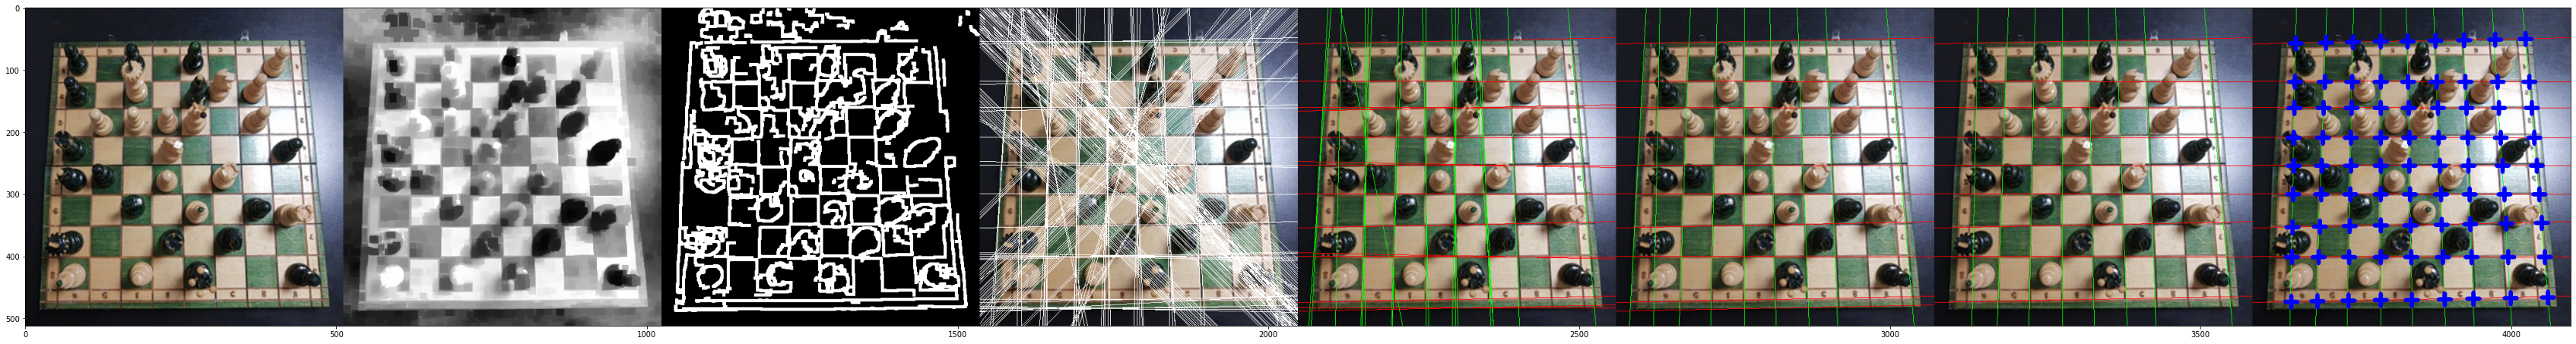

In [116]:
clear_prevoious_frames()
for path in ["test7.jpg"]:
    img = cv2.imread(path, cv2.IMREAD_COLOR)

    img = process_img(img)

    plt.figure(figsize = (60, 60))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

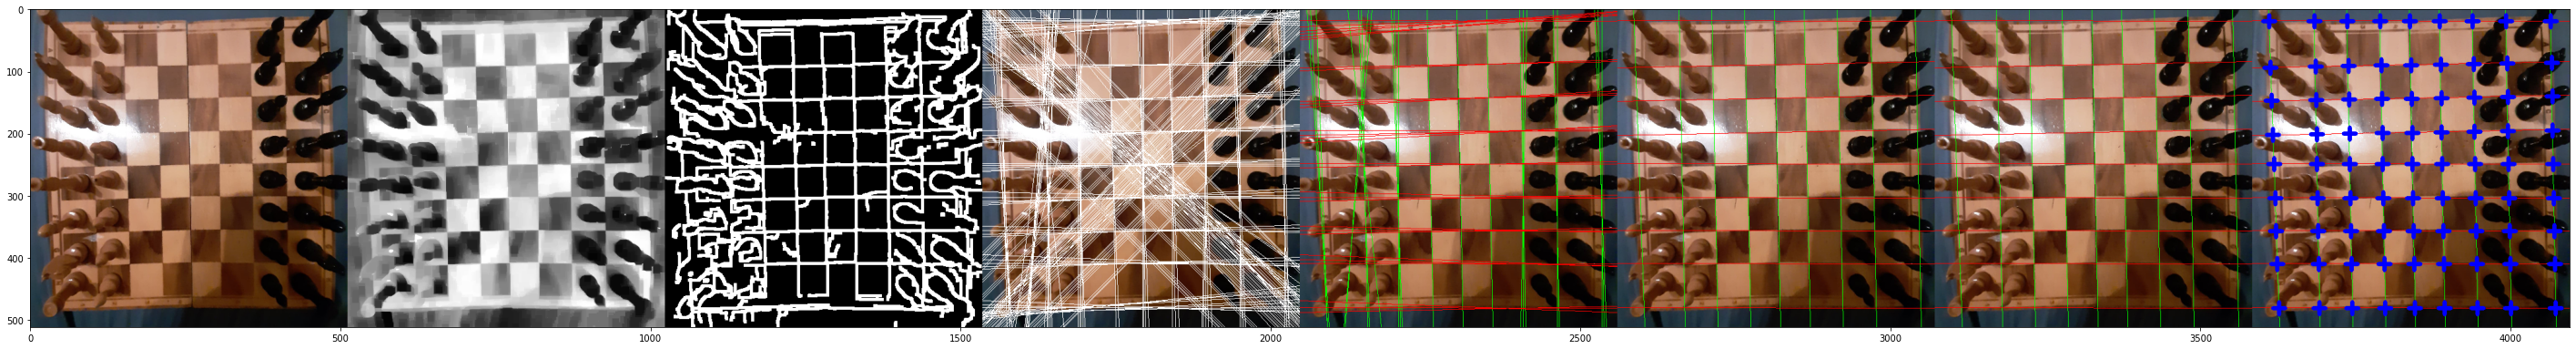

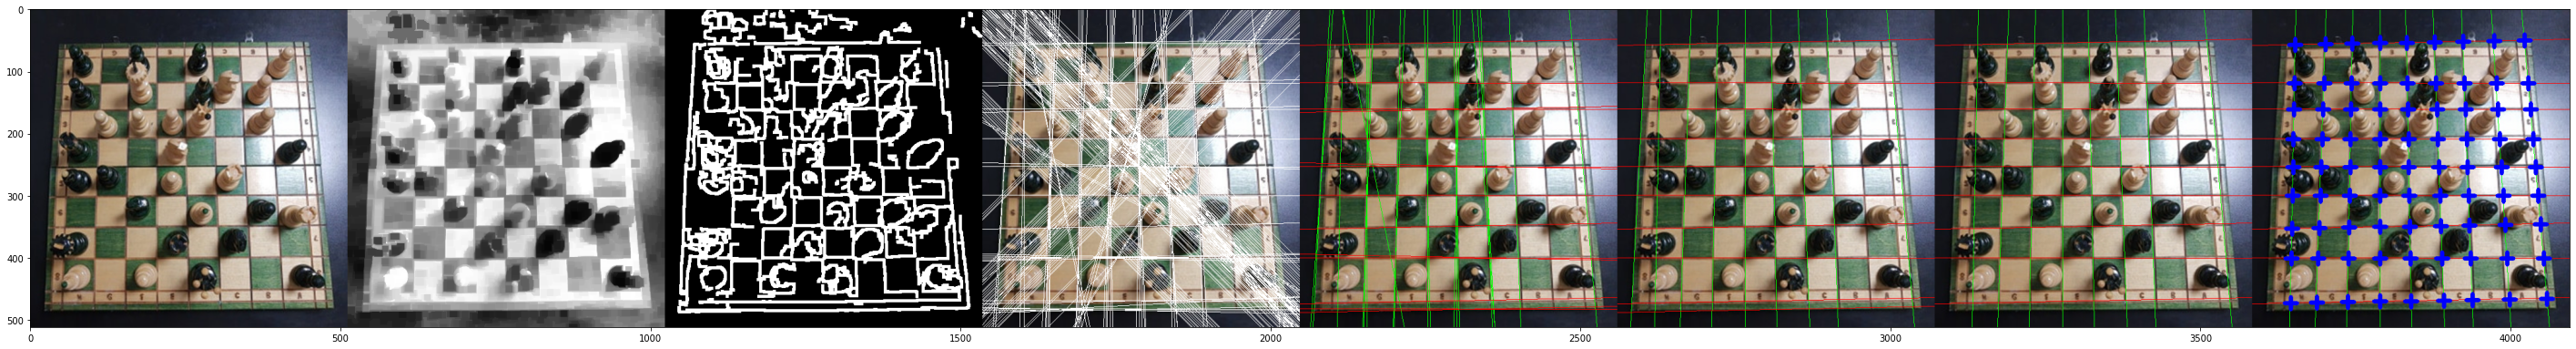

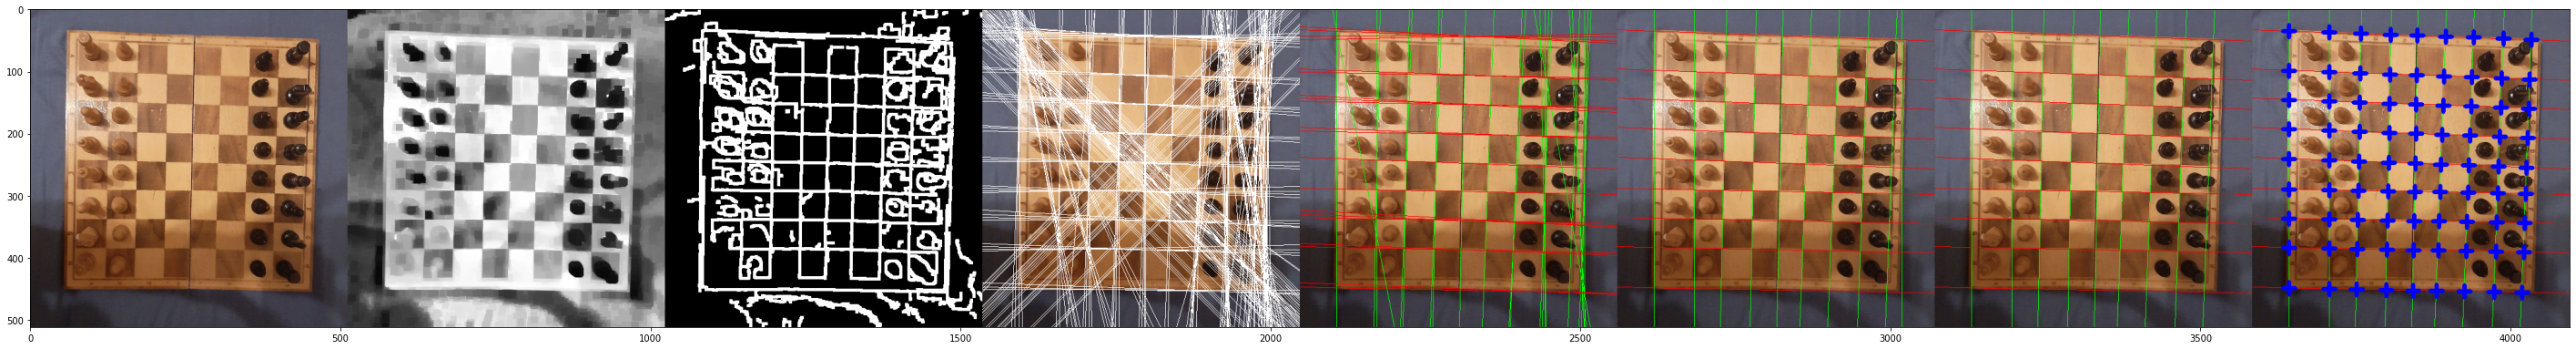

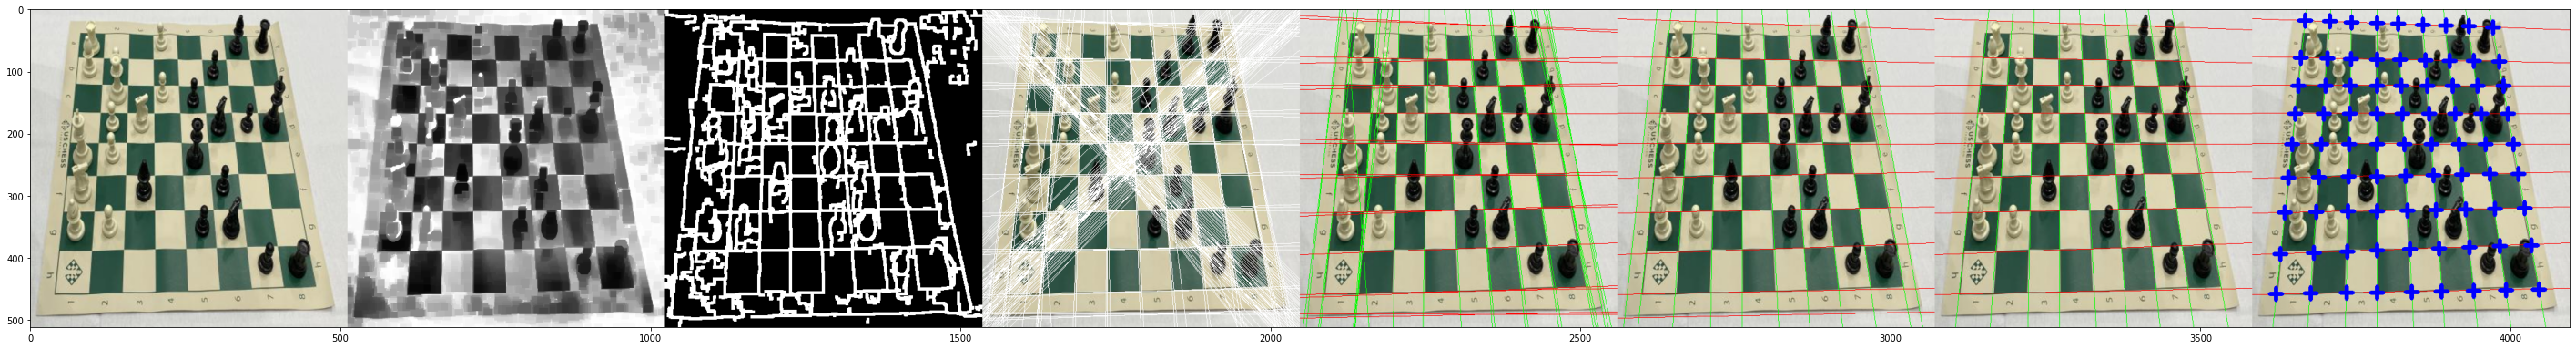

In [117]:
clear_prevoious_frames()
for path in ["test6.jpg", "test7.jpg", "test8.jpg", "test9.jpg"]:
    img = cv2.imread(path, cv2.IMREAD_COLOR)

    img = process_img(img)

    plt.figure(figsize = (50, 50))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

In [133]:
def process_samera_feed():
    try:
        cap = cv2.VideoCapture(0)
        if (cap.isOpened() == False):
            print("Unable to read camera feed")
            cap.release()
            return

        frame_width = int(cap.get(3))
        frame_height = int(cap.get(4))
        frame_size = min([frame_width, frame_height])

        print(f"Camera feed size : {frame_width} x {frame_height}")

        clear_prevoious_frames()
        while True:
            ret, frame = cap.read()

            t = time.time()

            frame = frame[(frame_height - frame_size)//2 : frame_height - (frame_height - frame_size)//2, (frame_width - frame_size)//2 : frame_width - (frame_width - frame_size)//2]

            try:
                frame = process_img(frame)
                frame = cv2.putText(frame, f"{1.0/(time.time() - t):.2f} fps", (30, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), thickness=2)
            except Exception as ex:
                frame = np.zeros([512, 1024, 3])
                frame = cv2.putText(frame, f"Error: {ex}", (30, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), thickness=2)

            if ret == True:
                # out.write(frame)
                cv2.imshow('processed', frame)
                # cv2.imshow('processed', cv2.resize(frame, (frame.shape[1]//2, frame.shape[0]//2)))
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
            else:
                break
    finally:
        cap.release()
        # out.release()
        cv2.destroyAllWindows()


process_samera_feed()

Camera feed size : 640 x 480


In [ ]:
def returnCameraIndexes():
    # checks the first 10 indexes.
    index = 0
    arr = []
    i = 10
    while i > 0:
        cap = cv2.VideoCapture(index)
        if cap.read()[0]:
            arr.append(index)
            cap.release()
        index += 1
        i -= 1
    return arr

returnCameraIndexes()

In [ ]:
# BEZUŻYTECZNY KAWAŁEK ZIEMNIAKA

# def mask_largest_contour(img):
#     img = img.copy()
#     blur = cv2.GaussianBlur(img, (11,11), 0)
#
#     thresh = cv2.adaptiveThreshold(blur, 255, 1, 1, 5, 2)
#     # thresh = cv2.dilate(thresh, np.ones([3, 3]), iterations=2)
#     # thresh = cv2.erode(thresh, np.ones([3, 3]), iterations=2)
#
#     # contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
#
#     plt.figure(figsize = (10,10))
#     plt.imshow(thresh)
#     plt.show()
#
#     # contour = max(contours, key=cv2.contourArea)
#
#     mask = np.zeros_like(img)
#     # cv2.drawContours(mask, [contour], 0, color=255, thickness=-1)
#     # cv2.drawContours(mask, [contour], 0, color=0, thickness=2)
#
#     rect = cv2.minAreaRect(cv2.findNonZero(thresh))
#     box = cv2.boxPoints(rect)
#     box = np.int0(box)
#     cv2.drawContours(mask,[box],0, 255,-1)
#
#     return mask
#
#
#
# img = cv2.imread("test8.jpg", cv2.IMREAD_COLOR)
# img = cv2.resize(img, (512, 512))
# original_img = img.copy()
#
# img = simplify_image(img, limit=3, grid=(3, 3), iters=5)
# mask = mask_largest_contour(img)
#
# plt.figure(figsize = (10,10))
# plt.imshow(original_img & cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR))
# plt.show()
#
# plt.figure(figsize = (10,10))
# plt.imshow(mask)
# plt.show()